In [1]:
import multiprocessing
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from tectosaur.mesh.mesh_gen import make_rect
from tectosaur_topo import solve_topo, evaluate_interior

In [3]:
import sys
sys.path.append('../common')
import gf_builder

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22

In [5]:
def topo(x, y, flat, C = [0, 0], hill_height = 2000, hill_R = 7000):
    z = np.zeros_like(x)
    if flat:
        return z

    z += hill_height * np.exp(
        -(((x - C[0]) / hill_R) ** 2 + ((y - C[1]) / hill_R) ** 2)
    )

    return z

def setup_model(surf_el_size, fault_el_size, flat, **kwargs):
    fault_top_z = -3 * 1000
    fault_bottom_z = -15 * 1000
    fault_length = 70 * 1000
    fault_nx = int(fault_length / fault_el_size)
    fault_ny = int((fault_top_z - fault_bottom_z) / fault_el_size)
    print('Fault has: ' + str((fault_nx - 1, fault_ny - 1)) + ' elements')
    
    corners = [
        [-fault_length / 2, 0, fault_bottom_z],
        [fault_length / 2, 0, fault_bottom_z],
        [fault_length / 2, 0, fault_top_z],
        [-fault_length / 2, 0, fault_top_z],
    ]
    fault = make_rect(fault_nx, fault_ny, corners)
    fault_slip = np.array([[1, 0, 0]] * 3 * fault[1].shape[0]).flatten()

    wx = 100 * 1000
    wy = 100 * 1000
    n = int(wx / surf_el_size)
    print('Surf has: ' + str((n - 1, n - 1)) + ' elements')
    
    surf_corners = [[-wx, -wy, 0], [-wx, wy, 0], [wx, wy, 0], [wx, -wy, 0]]
    surf = make_rect(n, n, surf_corners)
    surf[0][:,2] = topo(surf[0][:,0], surf[0][:,1], flat, **kwargs)
    return fault, fault_slip, surf

In [6]:
surf_el_size = 1000
fault_el_size = 2000
fault, fault_slip, hill_surf = setup_model(surf_el_size, fault_el_size, False)
_, _, flat_surf = setup_model(surf_el_size, fault_el_size, True)

Fault has: (34, 5) elements
Surf has: (99, 99) elements
Fault has: (34, 5) elements
Surf has: (99, 99) elements


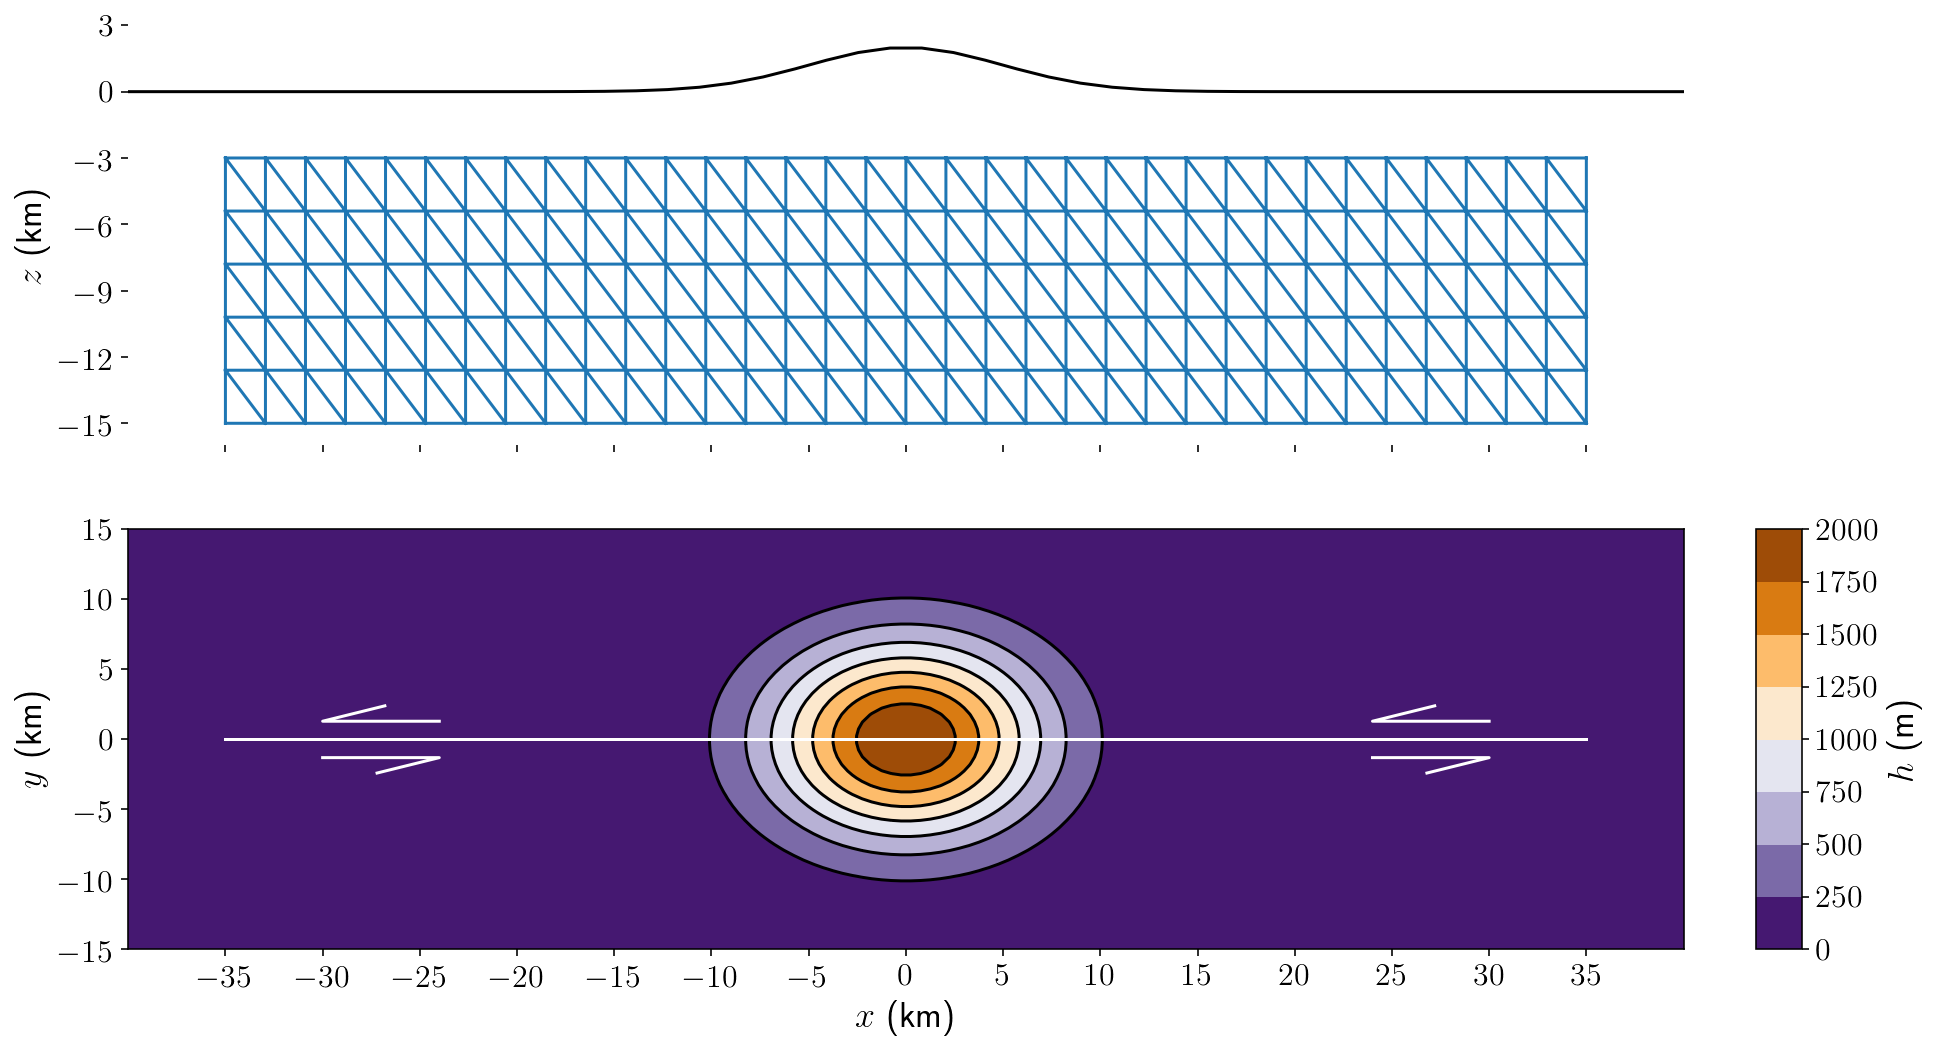

In [7]:
%matplotlib inline
x = np.linspace(-40000, 40000)
y = 0 * x
z = topo(x, y, flat = False)

fig = plt.figure(figsize = (15, 8.5))
ax1 = plt.subplot(211)
# ax1.set_aspect('equal')
triang = tri.Triangulation(fault[0][:,0] / 1000.0, fault[0][:,2] / 1000.0, fault[1])
plt.triplot(triang)
plt.xticks(np.linspace(-35.0, 35.0, 15))
plt.yticks(np.linspace(3.0, -15.0, 7))
plt.ylim([-16, 3])
# plt.xlabel('$x$ (km)')
plt.ylabel('$z$ (km)')
plt.plot(x / 1000, z / 1000, 'k-')
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.5)
cax.axis('off')
plt.setp(ax1.get_xticklabels(), visible=False)

x, y, z = hill_surf[0][:,0], hill_surf[0][:,1], hill_surf[0][:, 2]
nx = 400
ny = 400
x_new = np.linspace(np.min(x), np.max(x), nx)
y_new = np.linspace(np.min(y), np.max(y), ny)
X, Y = np.meshgrid(x_new, y_new)
Z = topo(X, Y, flat = False)
# Z = scipy.interpolate.griddata(
#     (x, y), z, (X, Y)
# )

ax2 = plt.subplot(212, sharex = ax1)
cmap = cm.get_cmap(name='PuOr_r')
cntf = plt.contourf(X / 1000, Y / 1000, Z, cmap = cmap)
try:
    plt.contour(
        X / 1000, Y / 1000, Z,
        linestyles = 'solid', colors=['k'], linewidths=[1.5]
    )
except ValueError:
    pass
plt.plot([-35.0, 35.0], [0.0, 0.0], 'w-', zorder = 1000)

plt.plot([-26.8,-30,-24], [2.4,1.3,1.3], 'w-')
plt.plot([-27.2,-24,-30], [-2.4,-1.3,-1.3], 'w-')
plt.plot([27.2,24,30], [2.4,1.3,1.3], 'w-')
plt.plot([26.8,30,24], [-2.4,-1.3,-1.3], 'w-')

plt.xlabel('$x$ (km)')
plt.ylabel('$y$ (km)')
plt.xlim([-40, 40])
plt.ylim([-15, 15])

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=0.5)
cbar = plt.colorbar(cntf, cax = cax)
cbar.set_label('$h$ (m)')
plt.savefig('hill_ss_mapview.pdf')
plt.show()

In [ ]:
def forward(surf, fault, fault_slip, gpu_idx):
    import logging
    logging.getLogger('tectosaur').setLevel(logging.WARNING)
    logging.getLogger('tectosaur_topo').setLevel(logging.WARNING)
    import os
    os.environ['CUDA_DEVICE'] = str(gpu_idx)
    return solve_topo(surf, fault, fault_slip, 1.0, 0.25)

In [51]:
with multiprocessing.Pool(2) as pool:
    hill_fut = pool.apply_async(forward, (hill_surf, fault, fault_slip, 0))
    flat_fut = pool.apply_async(forward, (flat_surf, fault, fault_slip, 1))
    hill_res = hill_fut.get()
    flat_res = flat_fut.get()
np.save('forward.npy', [*hill_res, *flat_res])
hill_surf_pts, hill_surf_disp, hill_soln, flat_surf_pts, flat_surf_disp, flat_soln = np.load('forward.npy')
assert(hill_soln.shape[0] == (hill_surf[1].shape[0] + fault[1].shape[0]) * 9)

2017-09-26 16:41:28,066 - tectosaur.util.gpu - DEBUG - start compiling nearfield/nearfield.cl
2017-09-26 16:41:28,115 - tectosaur.util.gpu - DEBUG - start compiling nearfield/nearfield.cl
2017-09-26 16:41:29,013 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 0
2017-09-26 16:41:29,538 - tectosaur.util.gpu - DEBUG - compile took 1.472226619720459
2017-09-26 16:41:29,563 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 1.4970777034759521
2017-09-26 16:41:29,572 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.006821632385253906
2017-09-26 16:41:29,591 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 1
2017-09-26 16:41:29,644 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.0704808235168457
2017-09-26 16:41:29,646 - tectosaur.util.gpu - DEBUG - start compiling nearfield/table_lookup.cl
2017-09-26 16:41:29,884 - tectosaur.util.gpu - DEBUG - compile took 1.7691214084625244
2017-09-26 16:41:29,9

2017-09-26 16:41:34,719 - tectosaur.fmm.builder - DEBUG - compression factor: 0.11955592797942637
2017-09-26 16:41:34,720 - tectosaur.fmm.builder - DEBUG - # obs pts: 79768
2017-09-26 16:41:34,722 - tectosaur.fmm.builder - DEBUG - # src pts: 79768
2017-09-26 16:41:34,724 - tectosaur.fmm.builder - DEBUG - total tree interactions: 7.607265e+08
2017-09-26 16:41:34,725 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 1.196520e+07
2017-09-26 16:41:34,726 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 0.000000e+00
2017-09-26 16:41:34,728 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.080125e+08
2017-09-26 16:41:34,729 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 4.980936e+08
2017-09-26 16:41:34,730 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 0.000000e+00
2017-09-26 16:41:34,732 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 1.196520e+07
2017-09-26 16:41:34,733 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 1.53

2017-09-26 16:41:36,502 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-26 16:41:36,505 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0009169578552246094
2017-09-26 16:41:36,518 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.17171430587768555
2017-09-26 16:41:36,525 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.004845142364501953
2017-09-26 16:41:36,530 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.003155946731567383
2017-09-26 16:41:36,568 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.034664154052734375
2017-09-26 16:41:36,569 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03773307800292969
2017-09-26 16:41:36,575 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0043222904205322266
2017-09-26 16:41:36,577 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.049643516540527344
2017-09-26 16:41:36,583 - tectosaur.ops.sparse_integ

2017-09-26 16:41:37,255 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0046977996826171875
2017-09-26 16:41:37,260 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.004521369934082031
2017-09-26 16:41:37,261 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.004495859146118164
2017-09-26 16:41:37,262 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05415821075439453
2017-09-26 16:41:37,266 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.24024343490600586
2017-09-26 16:41:37,268 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0009167194366455078
2017-09-26 16:41:37,270 - tectosaur_topo.solve - DEBUG - residual: 0.1318768428625786
2017-09-26 16:41:37,272 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-26 16:41:37,275 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0012218952178955078
2017-09-26 16:41:37,298 - tectosaur.fmm.evalu

2017-09-26 16:41:38,006 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0037088394165039062
2017-09-26 16:41:38,010 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0026047229766845703
2017-09-26 16:41:38,039 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.026130199432373047
2017-09-26 16:41:38,040 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0285947322845459
2017-09-26 16:41:38,044 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0026397705078125
2017-09-26 16:41:38,045 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.037456512451171875
2017-09-26 16:41:38,049 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0023834705352783203
2017-09-26 16:41:38,050 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04756283760070801
2017-09-26 16:41:38,054 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.242234468460083
2017-09-

2017-09-26 16:41:38,673 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05976295471191406
2017-09-26 16:41:38,679 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.2572042942047119
2017-09-26 16:41:38,682 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0014786720275878906
2017-09-26 16:41:38,684 - tectosaur_topo.solve - DEBUG - residual: 2.5048170930774446e-05
2017-09-26 16:41:38,686 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-26 16:41:38,689 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0013535022735595703
2017-09-26 16:41:38,761 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.20083379745483398
2017-09-26 16:41:38,766 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0033326148986816406
2017-09-26 16:41:38,772 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.004012346267700195
2017-09-26 16:41:38,800 - tectosaur.fmm.evaluator - DE

2017-09-26 16:41:39,375 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.004575252532958984
2017-09-26 16:41:39,412 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.03377795219421387
2017-09-26 16:41:39,413 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03628230094909668
2017-09-26 16:41:39,419 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00458979606628418
2017-09-26 16:41:39,421 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.050122737884521484
2017-09-26 16:41:39,425 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.002299785614013672
2017-09-26 16:41:39,426 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.060483455657958984
2017-09-26 16:41:39,432 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.24950575828552246
2017-09-26 16:41:39,435 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0014576911926269531
2017-

2017-09-26 16:41:40,038 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.22549009323120117
2017-09-26 16:41:40,040 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0008025169372558594
2017-09-26 16:41:40,042 - tectosaur_topo.solve - DEBUG - residual: 7.15988172558786e-07
2017-09-26 16:41:40,044 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-26 16:41:40,047 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0016090869903564453
2017-09-26 16:41:40,184 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.13542604446411133
2017-09-26 16:41:40,190 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0035715103149414062
2017-09-26 16:41:40,195 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0034215450286865234
2017-09-26 16:41:40,198 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.1785874366760254
2017-09-26 16:41:40,203 - tectosaur.ops.sparse_integra

2017-09-26 16:41:40,774 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0013813972473144531
2017-09-26 16:41:40,795 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0339045524597168
2017-09-26 16:41:40,796 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03618764877319336
2017-09-26 16:41:40,803 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.004487037658691406
2017-09-26 16:41:40,804 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.048623085021972656
2017-09-26 16:41:40,808 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0024094581604003906
2017-09-26 16:41:40,809 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05913281440734863
2017-09-26 16:41:40,814 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.26234865188598633
2017-09-26 16:41:40,817 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.001302957534790039
2017

In [9]:
flat_surf_pts_km = flat_surf_pts / 1000.0
d = 0
dimname = ['x', 'y', 'z'][d]

In [85]:
def pretty_surf_disp(fields, vmin, vmax, filename = None, test = False, show = True):
    all_axes = []
    for field_idx in range(len(fields)):
        subplot_idx = int(str(len(fields)) + '1' + str(field_idx + 1))
        if field_idx == 0:
            ax = plt.subplot(subplot_idx)
        else:
            ax = plt.subplot(subplot_idx, sharex = all_axes[0])
        all_axes.append(ax)
        ax.set_aspect('equal')

        field = fields[field_idx]
        cmap = cm.get_cmap(name='PuOr_r')
        levels = np.linspace(vmin[field_idx], vmax[field_idx], 17)

        if not test:
            triang = tri.Triangulation(flat_surf_pts_km[:,0], flat_surf_pts_km[:,1])
            refiner = tri.UniformTriRefiner(triang)
            tri_refi, interp_vals = refiner.refine_field(field, subdiv=2)
            cntf = plt.tricontourf(tri_refi, interp_vals, levels = levels, extend = 'both', cmap = cmap)
            plt.tricontour(tri_refi, interp_vals, levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 1.0)

        lw = 2
        plt.plot([-35,35], [0,0], 'k-', linewidth = lw * 2)
        plt.plot([-26.8,-30,-24], [2.4,1.3,1.3], 'k-', linewidth = lw)
        plt.plot([-27.2,-24,-30], [-2.4,-1.3,-1.3], 'k-', linewidth = lw)
        plt.plot([27.2,24,30], [2.4,1.3,1.3], 'k-', linewidth = lw)
        plt.plot([26.8,30,24], [-2.4,-1.3,-1.3], 'k-', linewidth = lw)
        plt.ylabel('$y ~\\mathrm{(km)}$')
        plt.ylim([-20,20])

        if field_idx < len(fields) - 1:
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            plt.xlabel('$x ~\\mathrm{(km)}$')
            plt.xlim([-50, 50])

        if not test:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.5)
            cbar = plt.colorbar(cntf, cax = cax)
            cbar.set_label('$u_' + dimname + ' ~\\mathrm{(m)}$')
            cbar.set_ticks(levels[::4])
            #cbar.set_ticklabels(['{:.3f}'.format(l) for l in levels[::4]])
    if filename is not None:
        plt.savefig(filename, bbox_inches = 'tight')
    if show:
        plt.show()
    return all_axes

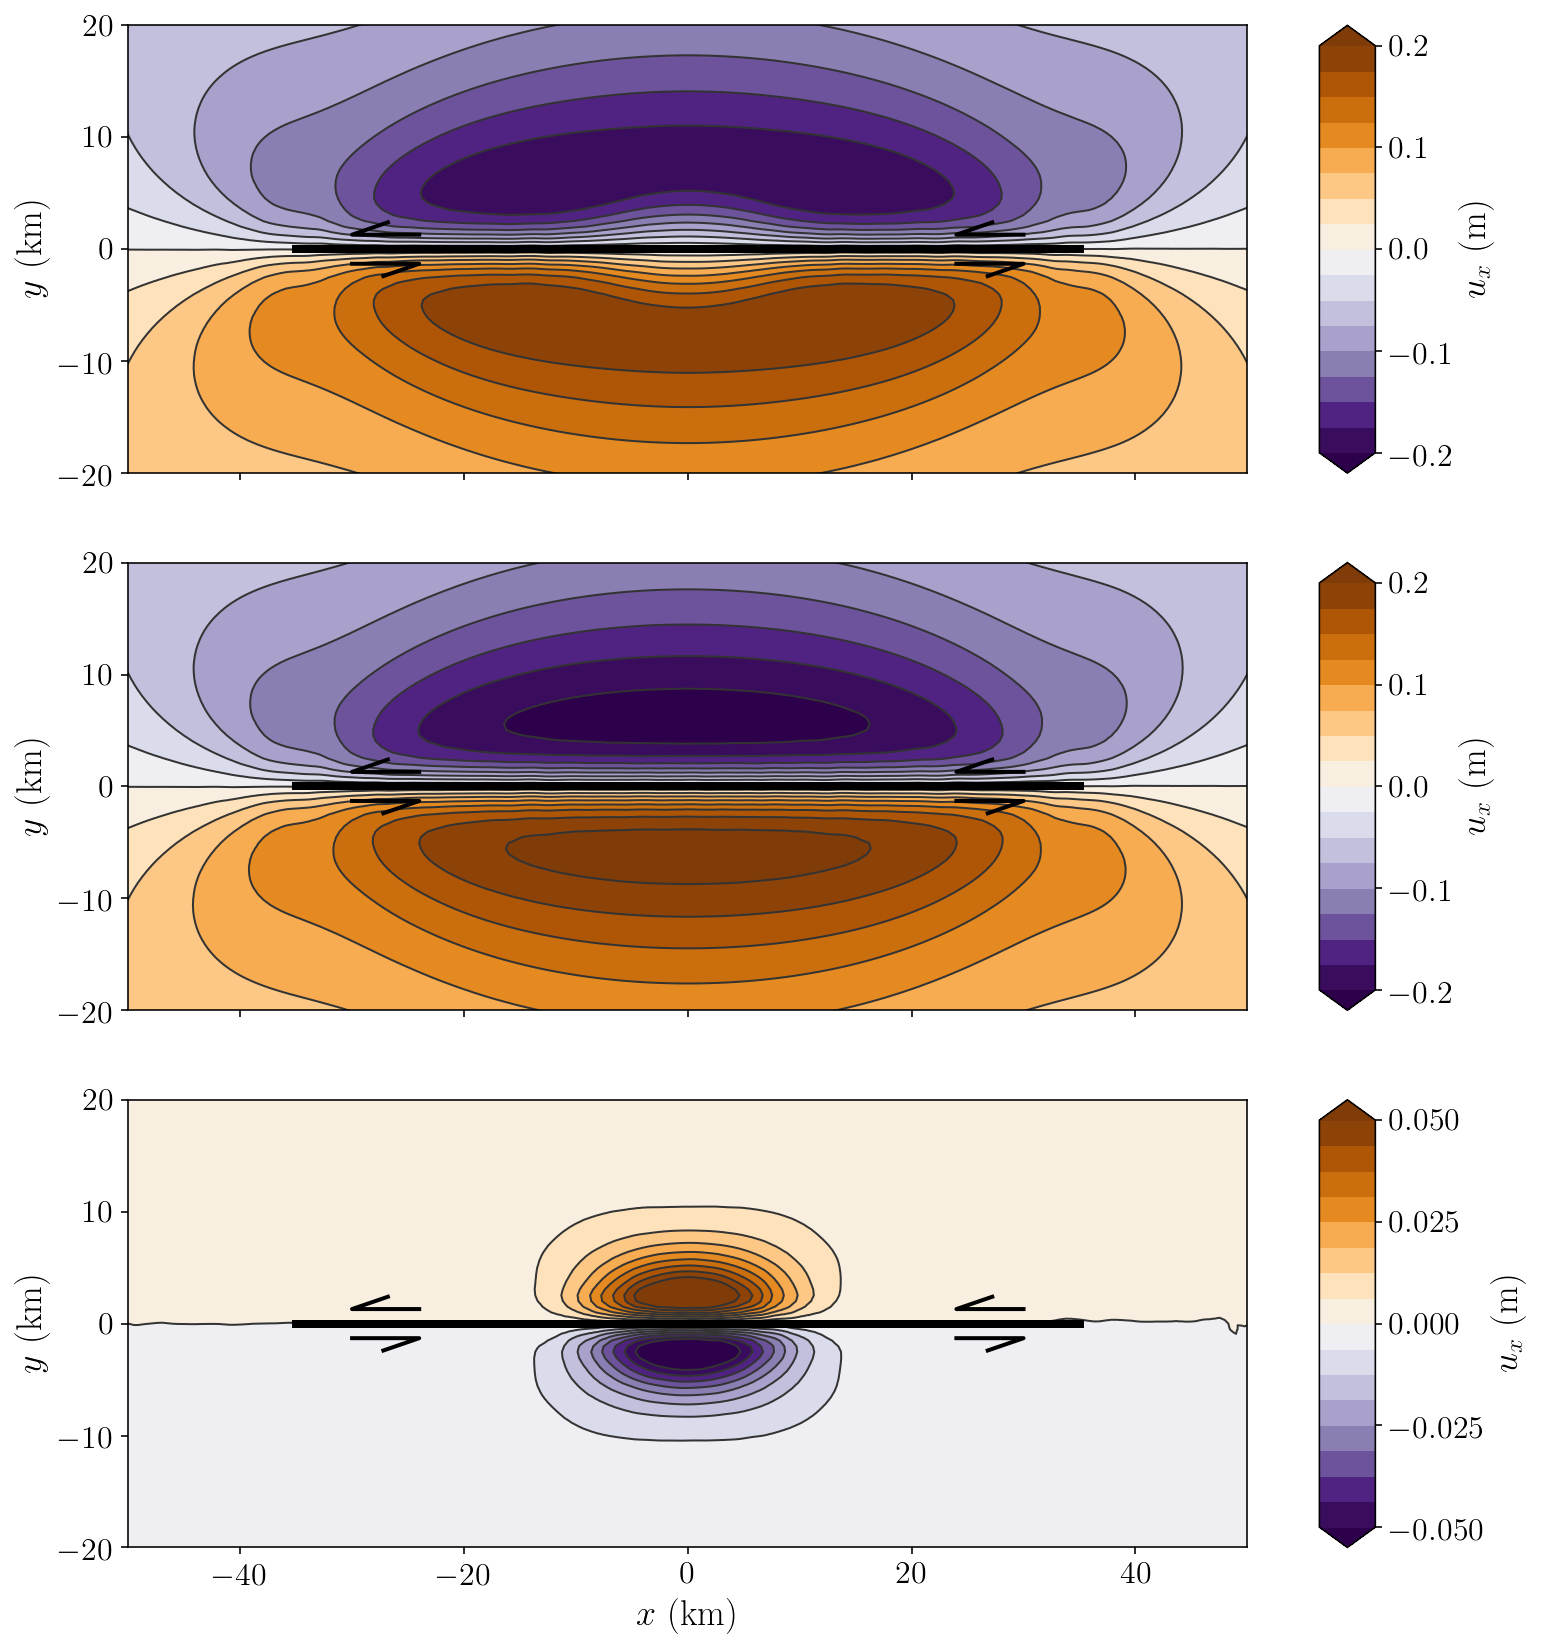

In [47]:
%matplotlib inline
plt.figure(figsize = (12,14))
pretty_surf_disp(
    [
        hill_surf_disp[:,d],
        flat_surf_disp[:,d],
        hill_surf_disp[:,d] - flat_surf_disp[:,d],
    ],
    [-0.2, -0.2, -0.05],
    [0.2, 0.2, 0.05]
)

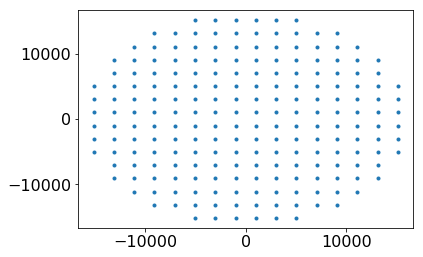

In [11]:
is_on_hill = hill_surf_pts[:,2] > 10.0
on_the_hill = hill_surf_pts[is_on_hill].copy()
on_the_hill[:,2] = 0.0
plt.plot(on_the_hill[:,0], on_the_hill[:,1], '.')
plt.show()

In [12]:
def interior():
    return interior_evaluate(on_the_hill, hill_surf, fault, hill_soln, 1.0, 0.25)

In [13]:
with multiprocessing.Pool(1) as pool:
    interior_disp = pool.apply_async(interior).get()
interior_disp = interior_disp.reshape((on_the_hill.shape[0], 3))
sea_level_hill_disp = hill_surf_disp.copy()
sea_level_hill_disp[is_on_hill] = interior_disp

HI
HI
HI
HI
2017-09-26 16:10:16,474 - tectosaur.util.gpu - DEBUG - start compiling farfield_direct.cl
2017-09-26 16:10:17,400 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 0
2017-09-26 16:10:18,801 - tectosaur.util.gpu - DEBUG - compile took 2.327834129333496


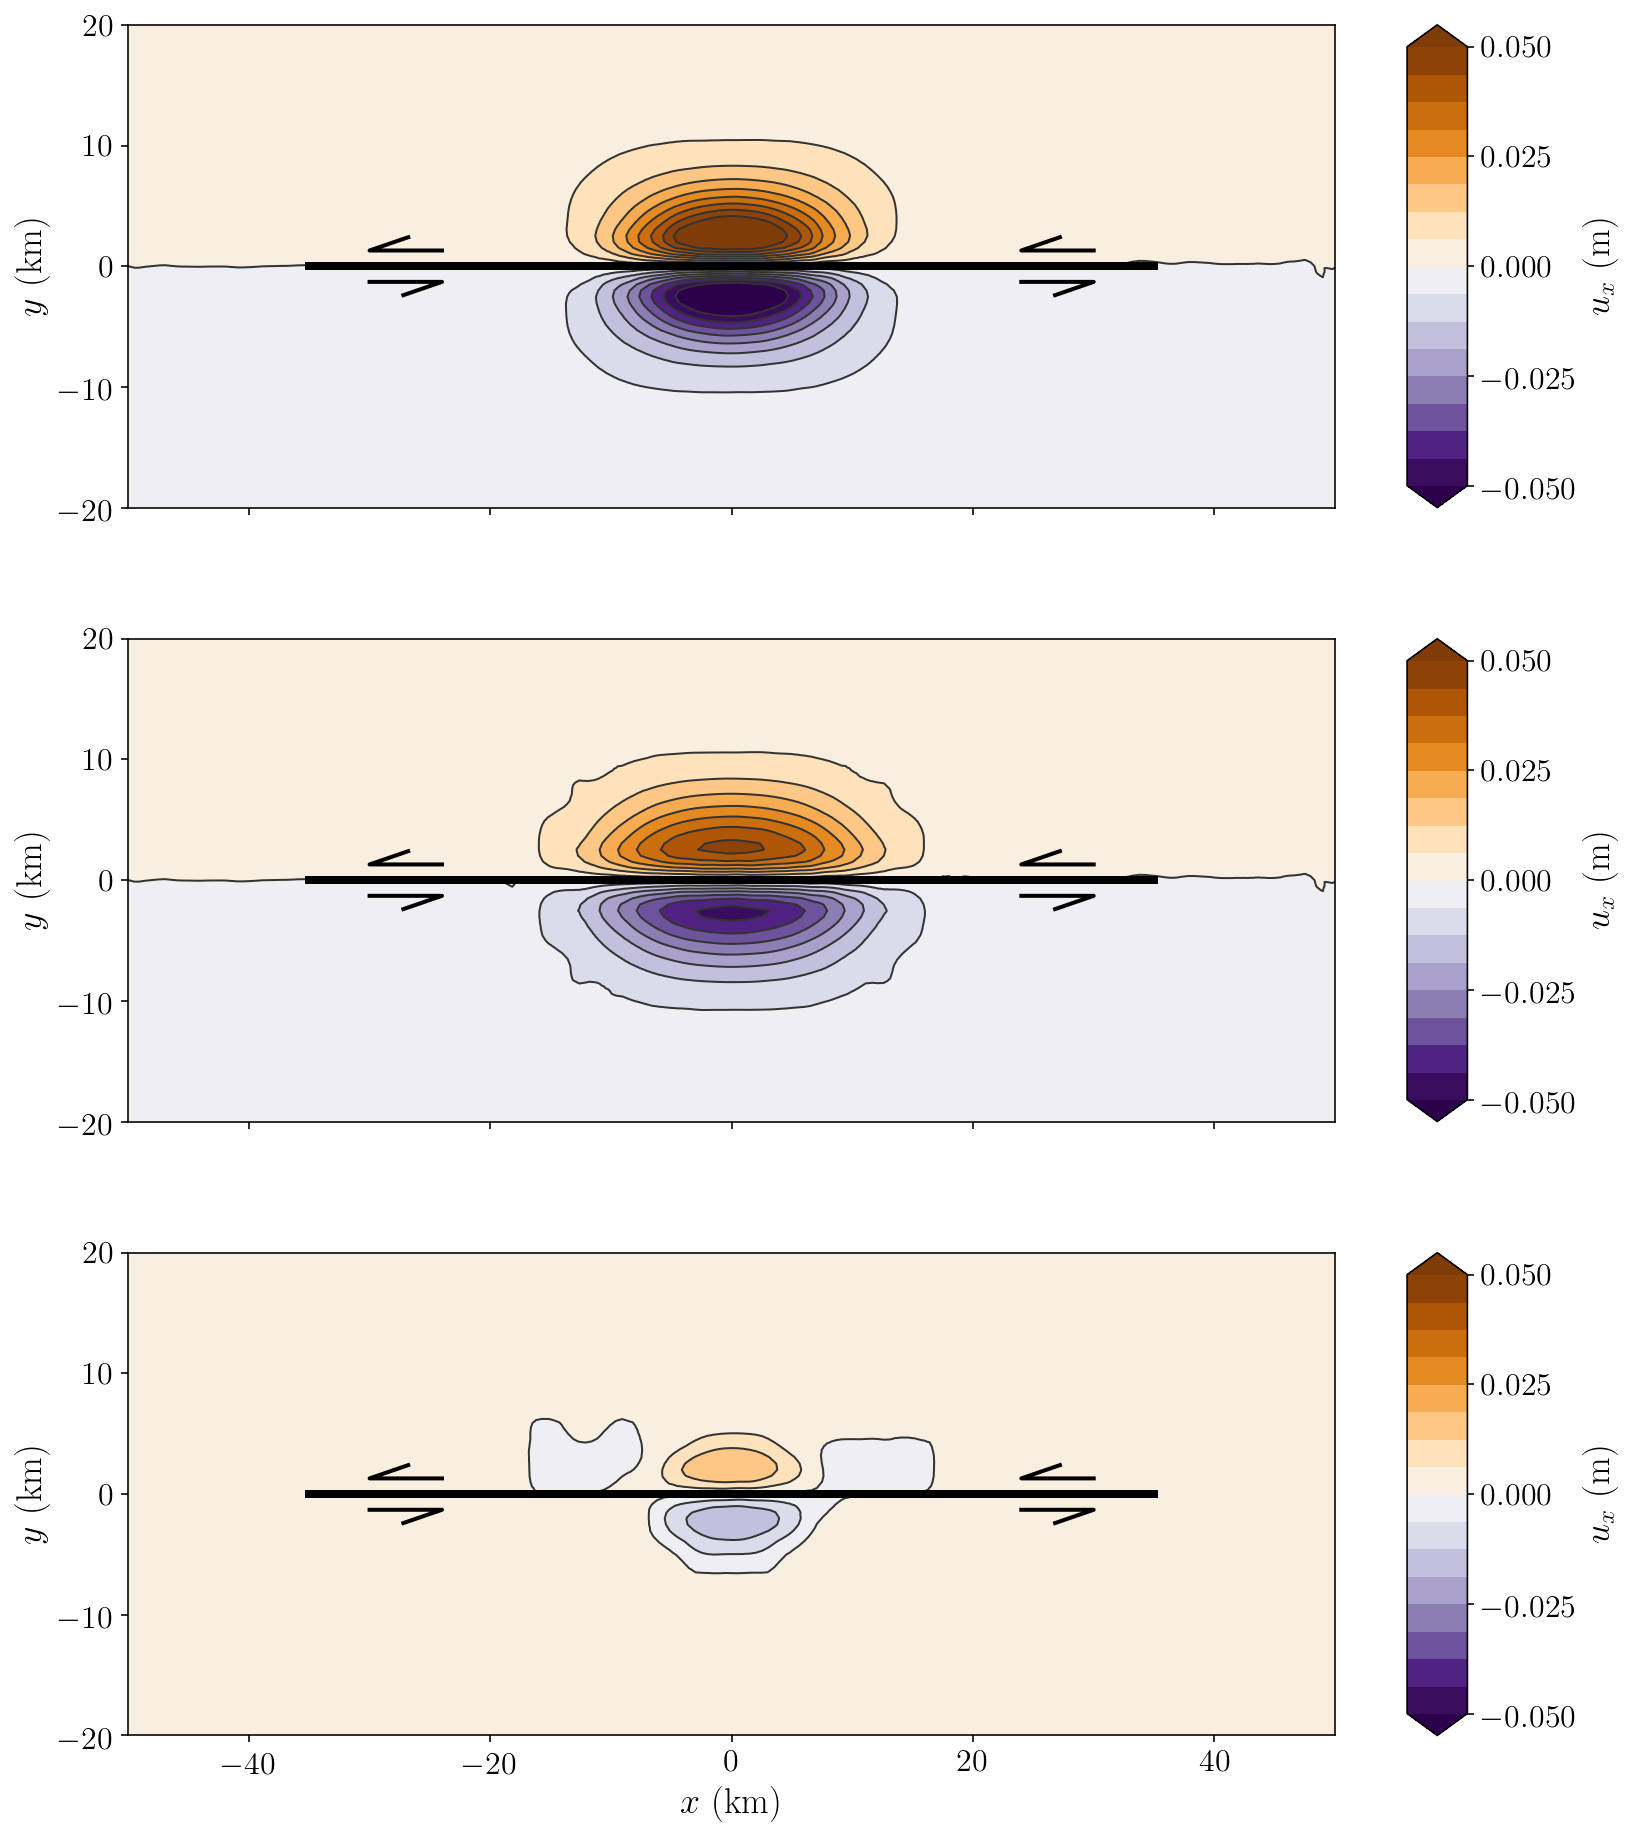

In [46]:
plt.figure(figsize = (12, 16))
total_effect = hill_surf_disp[:,d] - flat_surf_disp[:,d]
bc_effect = sea_level_hill_disp[:,d] - flat_surf_disp[:,d]
dist_effect = hill_surf_disp[:,d] - sea_level_hill_disp[:,d]
dist_effect[np.abs(dist_effect) < 0.002] = 0.001
pretty_surf_disp(
    [total_effect, bc_effect, dist_effect], 
    [-0.05,-0.05,-0.05], 
    [0.05,0.05,0.05],
    'bc_vs_dist.pdf',
    test = False
)

Fault has: (34, 5) elements
Fault has: (34, 5) elements


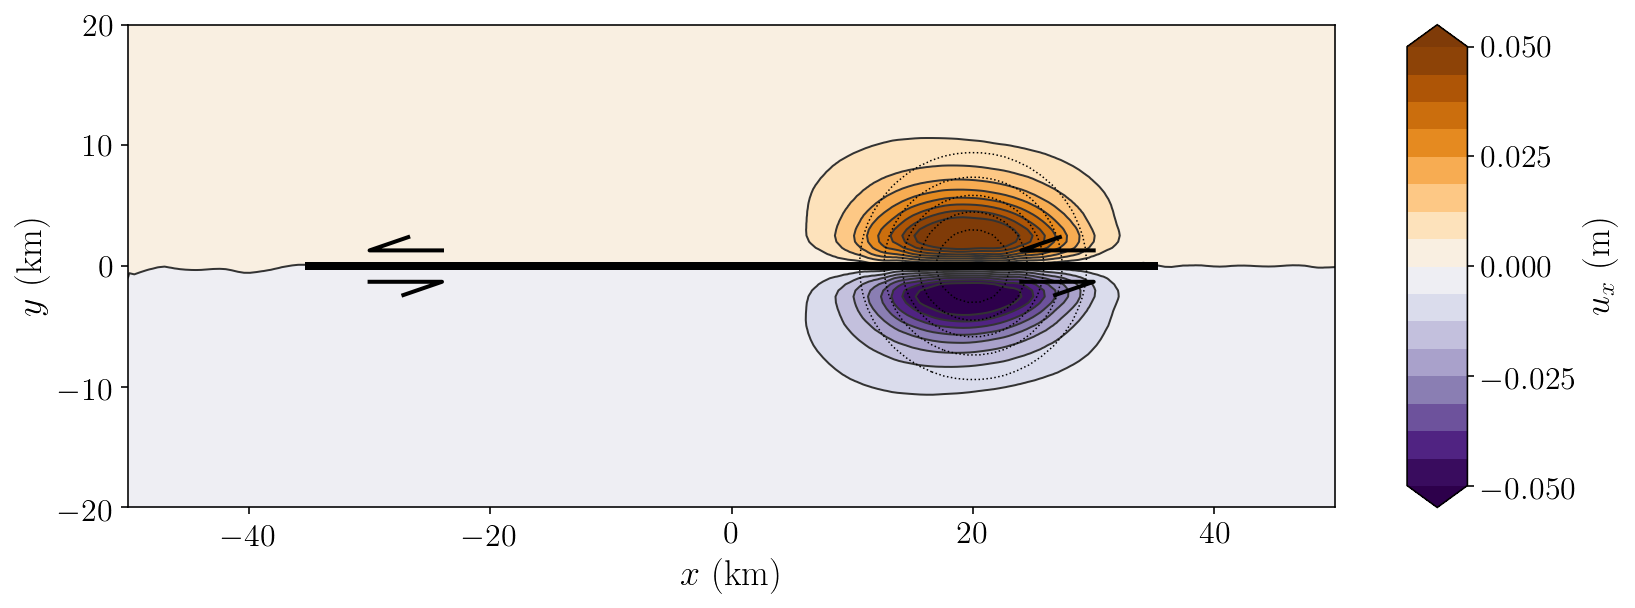

In [117]:
def move_the_hill(**kwargs):
    filename = 'move_the_hill_' + str(kwargs['C'][0]) + '-' + str(kwargs['C'][1]) + '.pdf'
    surf_el_size = 1000
    fault_el_size = 2000
    fault, fault_slip, hill_surf = setup_model(surf_el_size, fault_el_size, False, **kwargs)
    _, _, flat_surf = setup_model(surf_el_size, fault_el_size, True)
    with multiprocessing.Pool(2) as pool:
        hill_fut = pool.apply_async(forward, (hill_surf, fault, fault_slip, 0))
        flat_fut = pool.apply_async(forward, (flat_surf, fault, fault_slip, 1))
        hill_res = hill_fut.get()
        flat_res = flat_fut.get()
    hill_surf_pts, hill_surf_disp, hill_soln, flat_surf_pts, flat_surf_disp, flat_soln = [*hill_res, *flat_res]
#     hill_surf_pts, hill_surf_disp, hill_soln, flat_surf_pts, flat_surf_disp, flat_soln = np.load('forward.npy')
    plt.figure(figsize = (12,8))
    axs = pretty_surf_disp(
        [
            hill_surf_disp[:,d] - flat_surf_disp[:,d]
        ],
        [-0.05],
        [0.05],
        show = False,
        test = False
    )
#     C = (np.array(kwargs['C']) / 1000.0).tolist()
#     circle = plt.Circle(C, 1.0, color = 'w', zorder = 100)
#     axs[0].add_artist(circle)
    x, y, z = hill_surf[0][:,0], hill_surf[0][:,1], hill_surf[0][:, 2]
    nx = 200
    ny = 200
    x_new = np.linspace(np.min(x), np.max(x), nx)
    y_new = np.linspace(np.min(y), np.max(y), ny)
    X, Y = np.meshgrid(x_new, y_new)
    Z = topo(X, Y, flat = False, **kwargs)
    levels = np.linspace(np.min(Z), np.max(Z), 7)
    axs[0].contour(
        X / 1000, Y / 1000, Z,
        linestyles = 'dotted', colors=['k'], linewidths=[0.75],
        zorder = 100, levels = levels
    )
    plt.savefig(filename, bbox_inches = 'tight')
    plt.show()
#move_the_hill(C = [0,0])
move_the_hill(C = [20000,0])

Fault has: (34, 5) elements
Fault has: (34, 5) elements


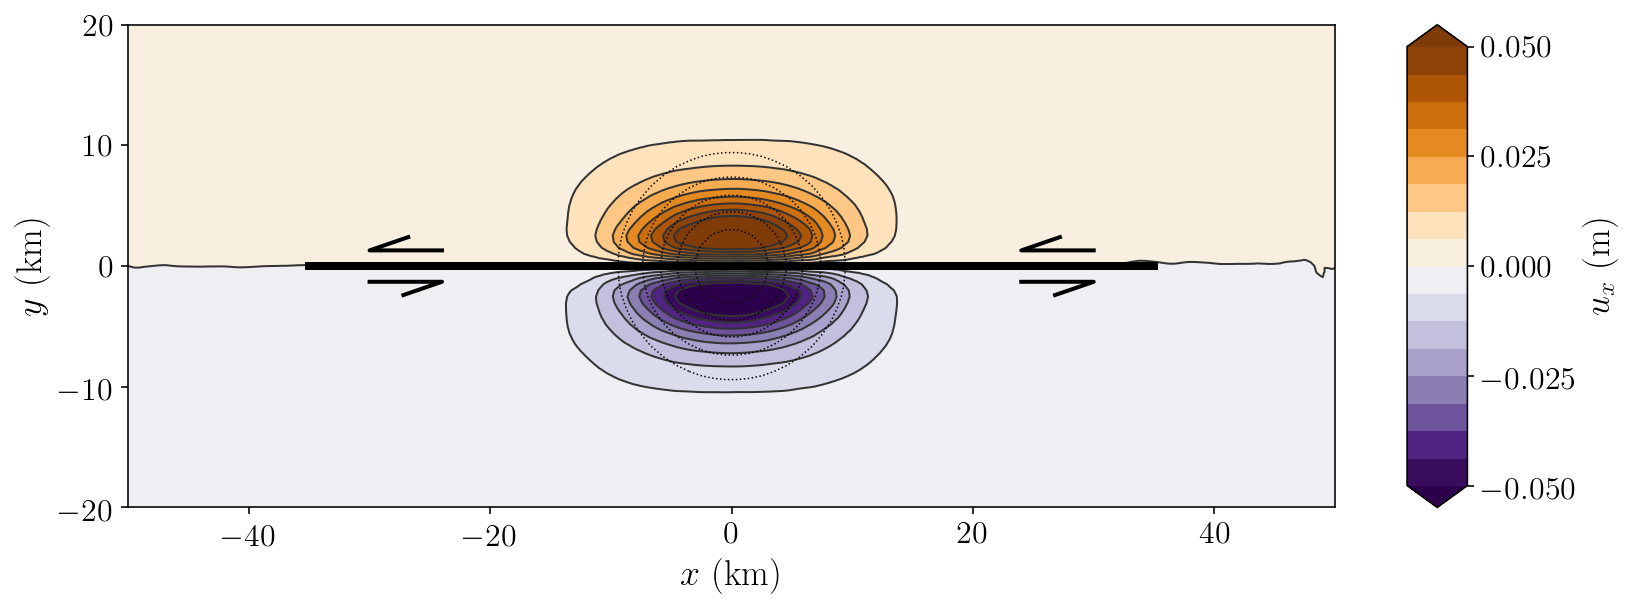

Fault has: (34, 5) elements
Fault has: (34, 5) elements


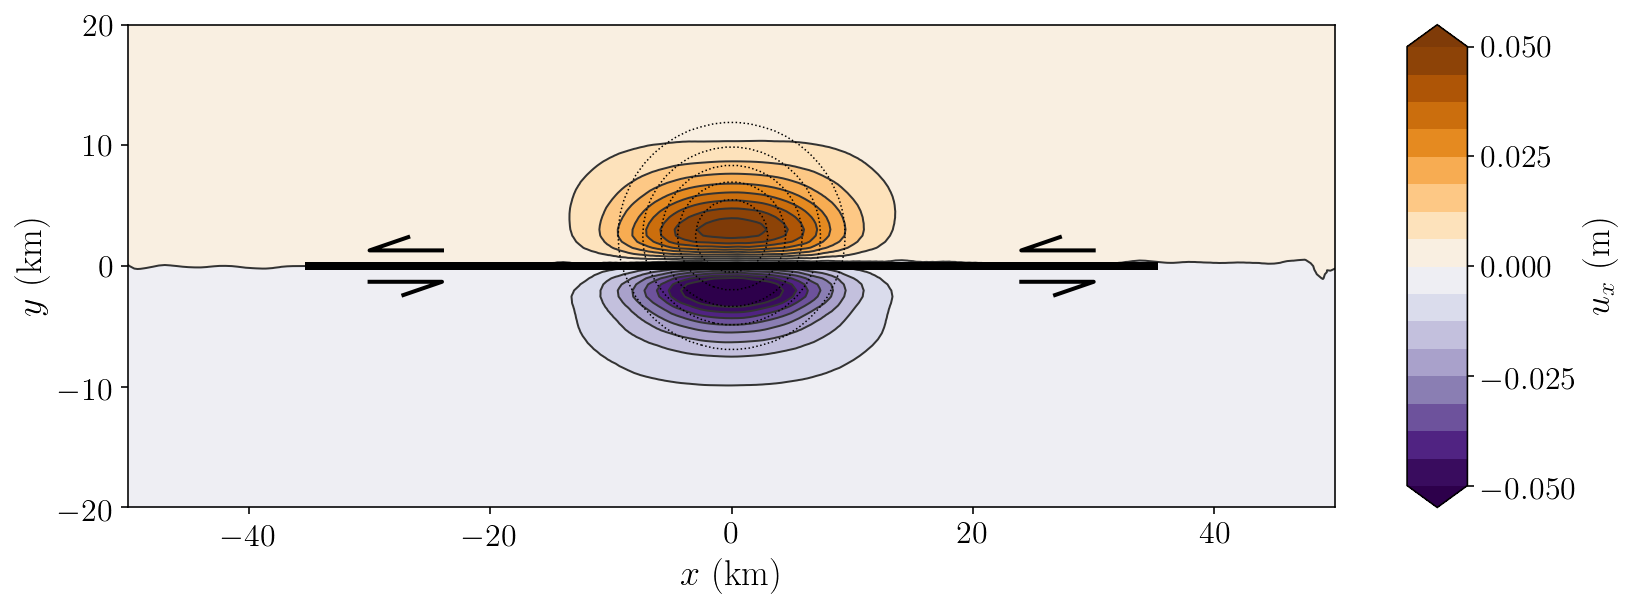

Fault has: (34, 5) elements
Fault has: (34, 5) elements


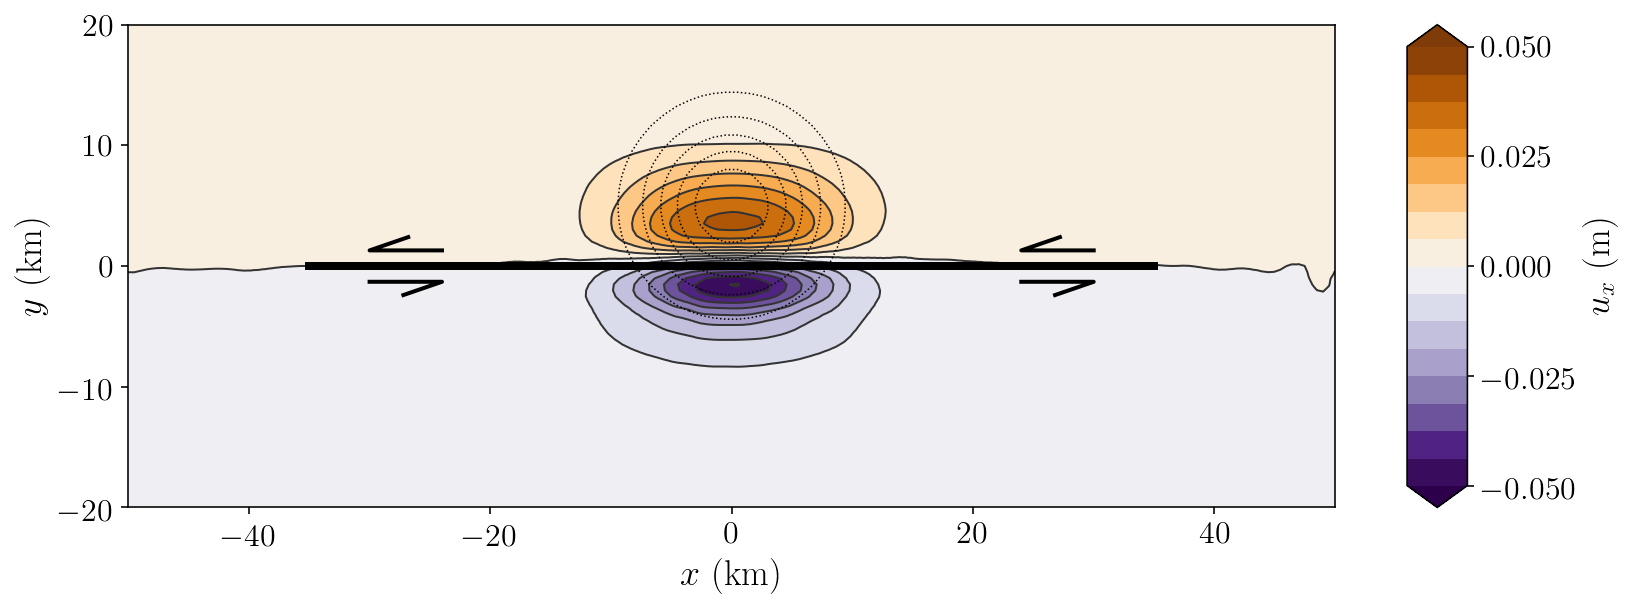

Fault has: (34, 5) elements
Fault has: (34, 5) elements


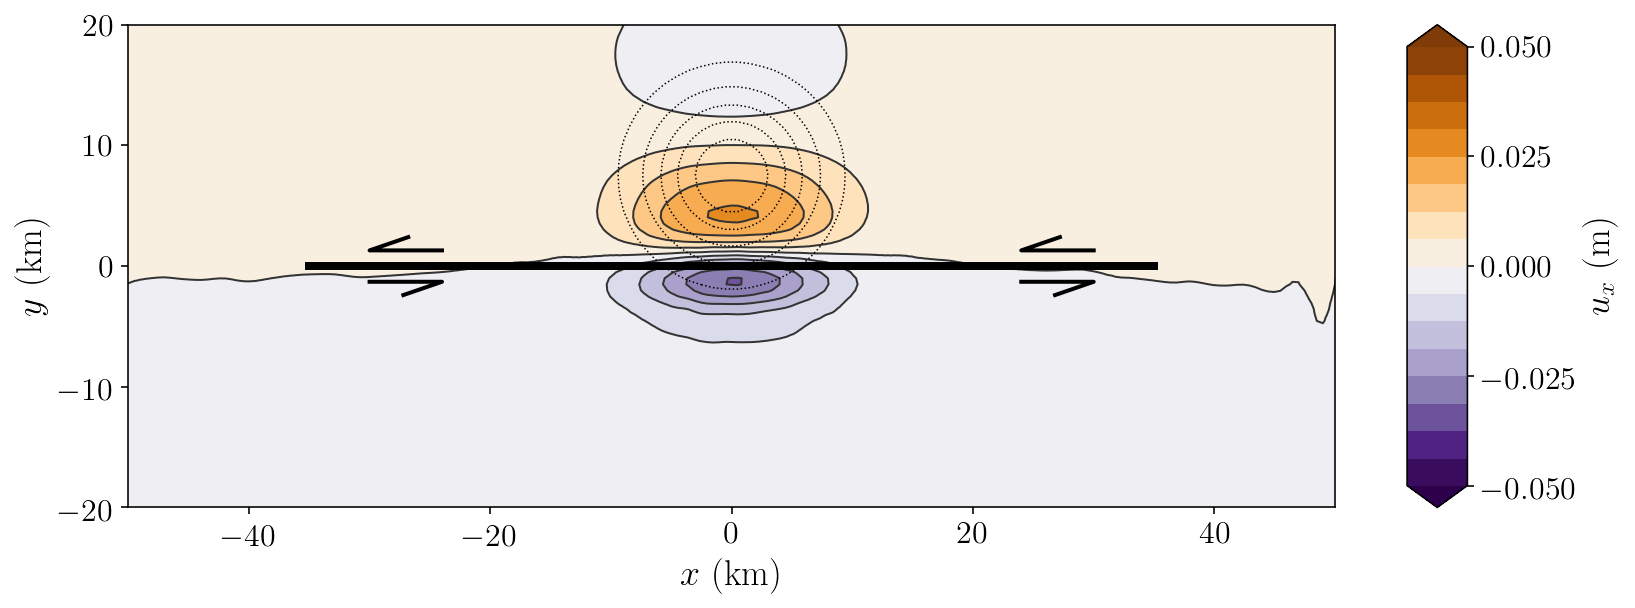

Fault has: (34, 5) elements
Fault has: (34, 5) elements


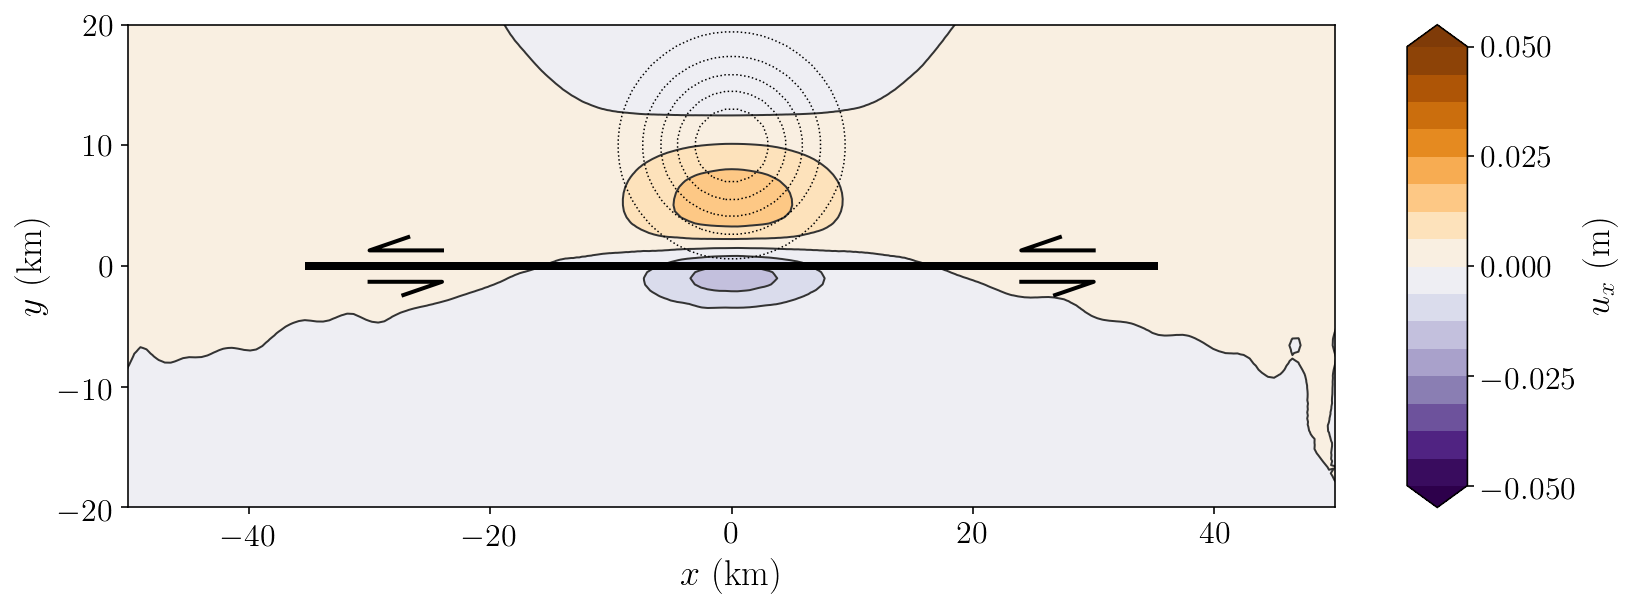

Fault has: (34, 5) elements
Fault has: (34, 5) elements


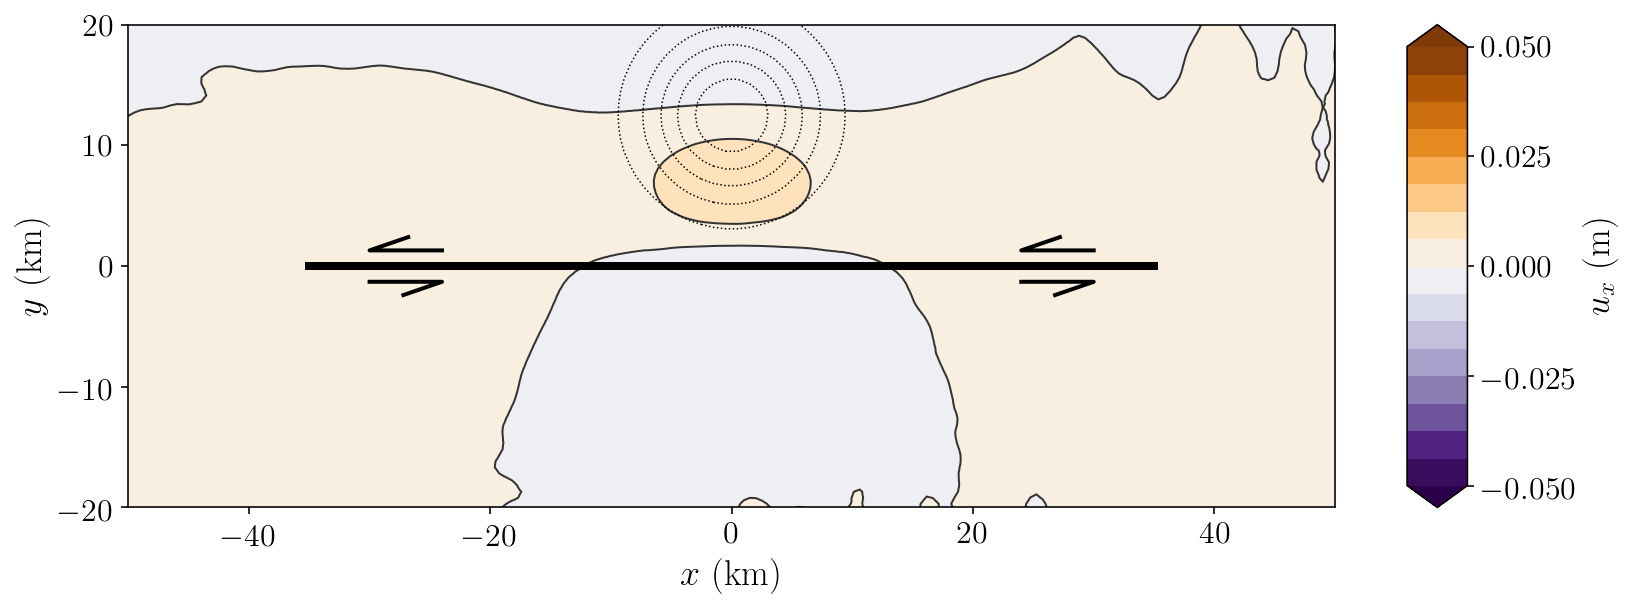

Fault has: (34, 5) elements
Fault has: (34, 5) elements


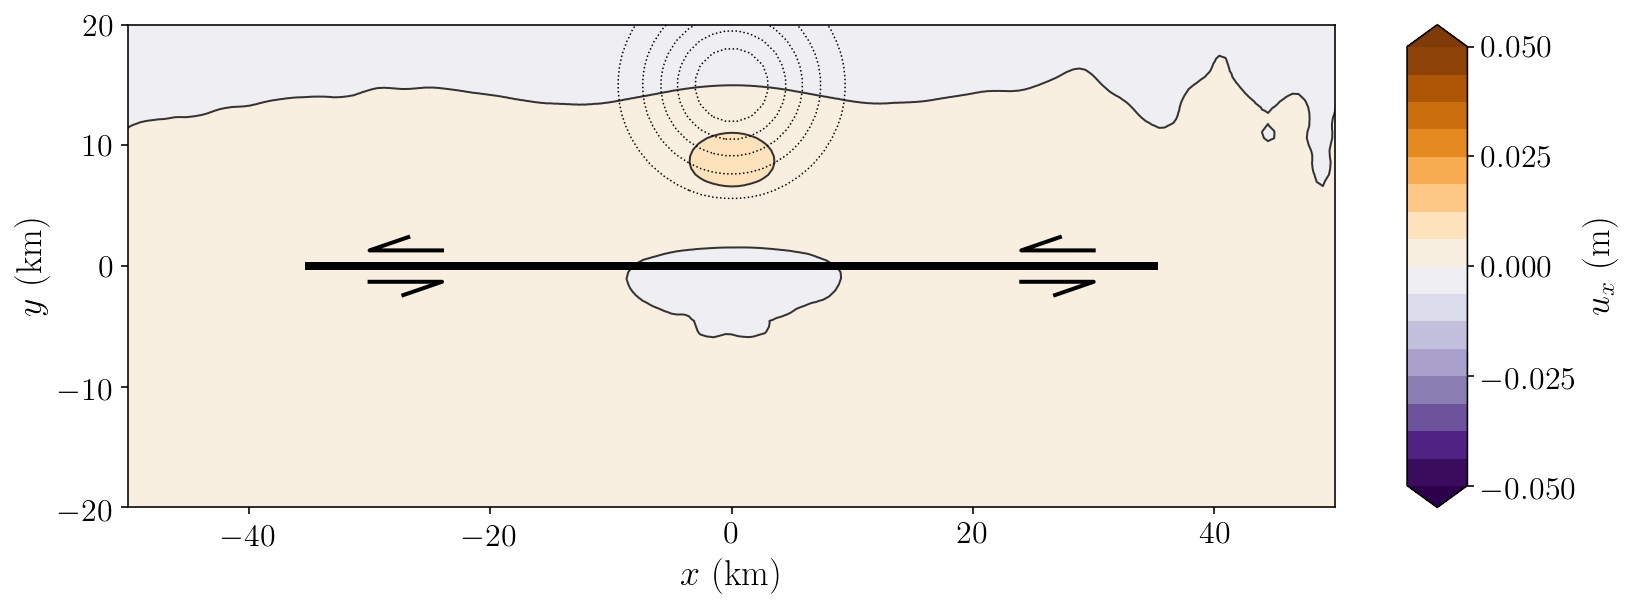

In [118]:
move_the_hill(C = [0,0])
move_the_hill(C = [0,2500])
move_the_hill(C = [0,5000])
move_the_hill(C = [0,7500])
move_the_hill(C = [0,10000])
move_the_hill(C = [0,12500])
move_the_hill(C = [0,15000])

In [13]:
def gf_runner(args):
    proc_idx, flat = args
    n_gpus = 8
    import os
    os.environ['CUDA_DEVICE'] = str(proc_idx % n_gpus)
    import logging
    logging.getLogger('tectosaur').setLevel(logging.WARNING)
    logging.getLogger('tectosaur_topo').setLevel(logging.WARNING)
    surf = flat_surf if flat else hill_surf
    max_tri_size = 25000
    return gf_builder.build_greens_functions(
        surf, fault, max_tri_size, None, proc_idx, n_procs
    )

In [70]:
# For a 50x50 fault surface:
# took 3576s with 1 proc
# took 271s with 16 proc
# took 187s with 32 proc
# For a 200x200 fault surface:
# took 1908s with 32 proc
# n_procs = 32
# with multiprocessing.Pool(n_procs) as pool:
#     for flat in [False, True]:
#         gf_results = pool.map(gf_runner, zip(range(n_procs), [flat] * n_procs))
#         surf_pts, slip_vecs, gfs = gf_builder.combine_gfs(fault, gf_results)
#         filename = ('flat' if flat else 'hill') + '_gfs.npy'
#         np.save(filename, [surf_pts, slip_vecs, gfs])
n_surfx = int(np.sqrt(flat_surf[0].shape[0]))
print(n_surfx)
directory = 'gfs' + str(n_surfx)
# directory = '.'
flat_surf_pts, slip_vecs, flat_gfs = np.load(directory + '/flat_gfs.npy')
hill_surf_pts, _, hill_gfs = np.load(directory + '/hill_gfs.npy')

100


In [81]:
obs_pt_idxs = np.random.randint(flat_surf_pts.shape[0], size = (1000,))
obs_pt_idxs = np.arange(flat_surf_pts.shape[0])
which_dims = [0,1,2]
noise_magnitude = 0.0
slip = np.array([3.5, 0.0, 0.0])
reg_param = 0.045

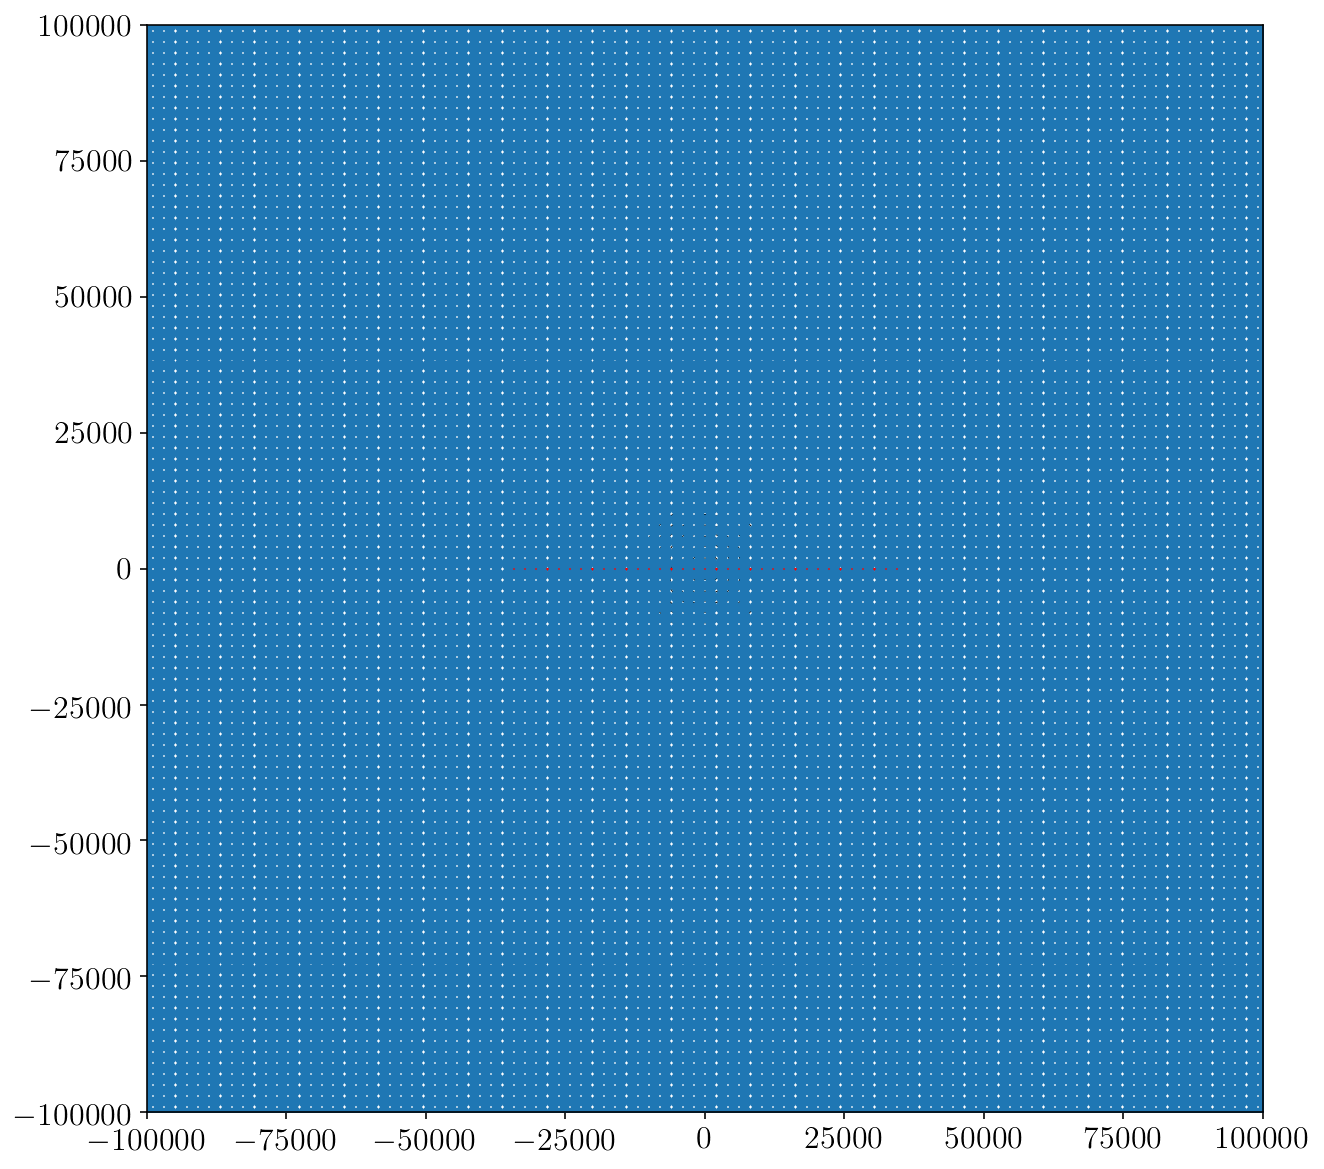

In [82]:
from scipy.interpolate import griddata
w = np.max(hill_surf_pts[:,0])
xi = np.linspace(-w,w,100)
yi = np.linspace(-w,w,100)

z = hill_surf_pts[:, 2]
zi = griddata((hill_surf_pts[:,0], hill_surf_pts[:,1]), z, (xi[None,:], yi[:,None]), method='cubic')

min_z, max_z = np.min(z), np.max(z)
levels = np.linspace(min_z, max_z, 15)[1:]
plt.figure(figsize = (10,10))
CS = plt.contour(xi,yi,zi,levels = levels, linewidths=0.5, colors='k')

min_faultx = np.min(fault[0][:,0])
max_faultx = np.max(fault[0][:,0])

plt.plot([min_faultx, max_faultx], [0,0], 'r-')
plt.plot(flat_surf_pts[obs_pt_idxs,0], flat_surf_pts[obs_pt_idxs,1], 'o')
plt.show()

# Plot the location of observation point (blue dots) the fault (red line), topo (background contours).
# Not intended to be pretty, just for orienting myself!

In [83]:
rhs_G = hill_gfs
inv_rhs = np.zeros(obs_pt_idxs.shape[0] * len(which_dims))
for i in range(rhs_G.shape[0]):
    s = slip_vecs[i,0,:]
    # project the desired slip vector onto the gf slip vectors.
    proj = s.dot(slip) / np.linalg.norm(s)
    # sum to resulting rhs
    inv_rhs += proj * rhs_G[i,obs_pt_idxs,:][:,which_dims].flatten()
inv_rhs += np.random.normal(0, noise_magnitude, inv_rhs.shape[0])

xs = []
# for reg_param in (2.0 ** (-np.arange(16))):
for G in [flat_gfs, hill_gfs]:
    A1 = G[:,obs_pt_idxs][:,:,which_dims].reshape((G.shape[0], -1)).T
    A2 = reg_param * np.eye(*A1.shape)
    A = np.vstack((A1, A2))
    full_rhs = np.hstack((inv_rhs, np.zeros(A2.shape[0])))
    x = np.linalg.lstsq(A, full_rhs)[0]
    xs.append(x)

(30000, 680) (30000, 680) (60000, 680) (60000,)
(30000, 680) (30000, 680) (60000, 680) (60000,)


In [104]:
for digits in range(1, 14):
    tol = 10 ** (-digits)
    R = scipy.sparse.linalg.lsmr(A, full_rhs, atol = tol, btol = tol)
    print(digits, R[2])

1 2
2 8
3 12
4 16
5 19
6 25
7 29
8 33
9 36
10 40
11 45
12 49
13 52


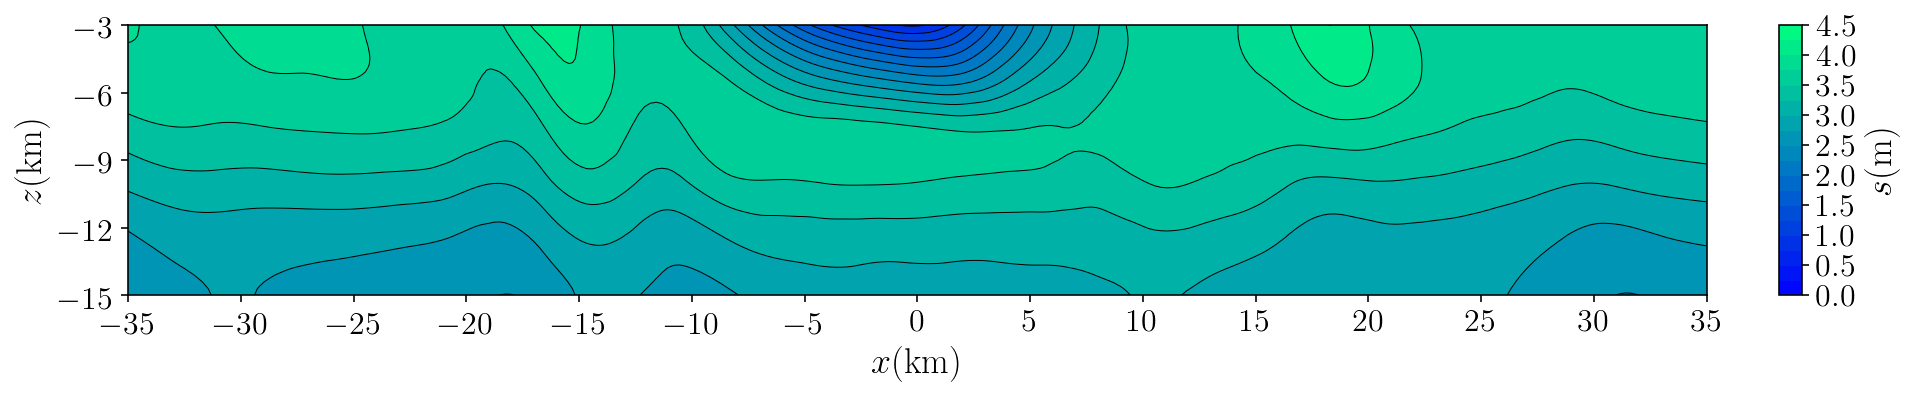

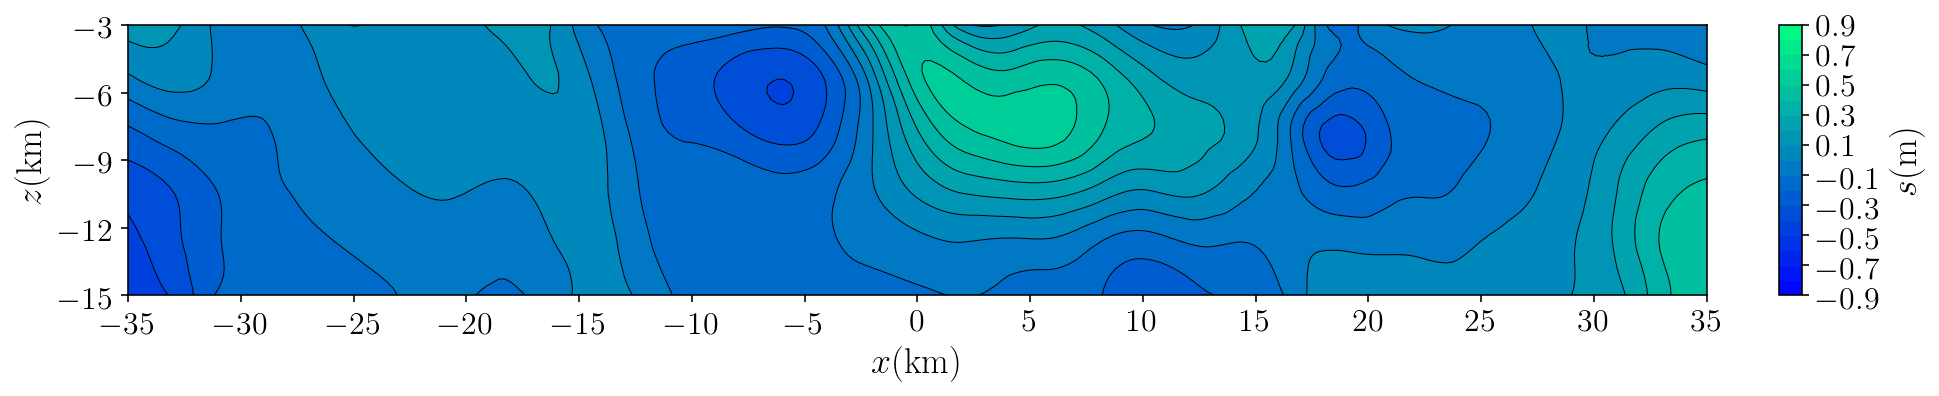

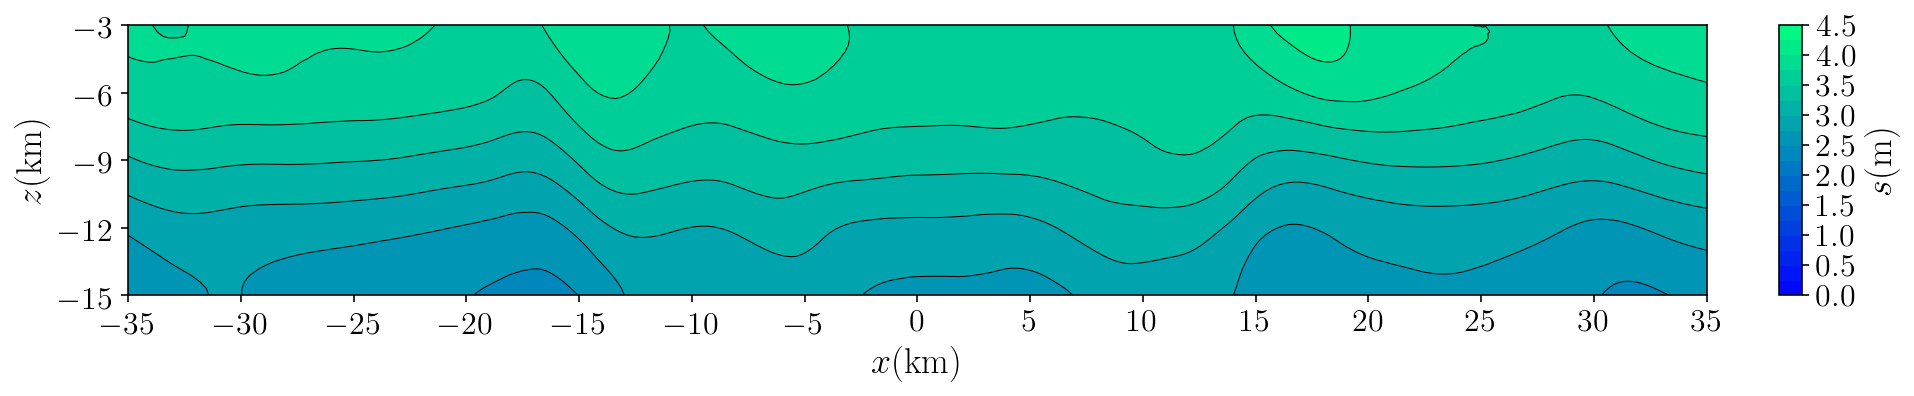

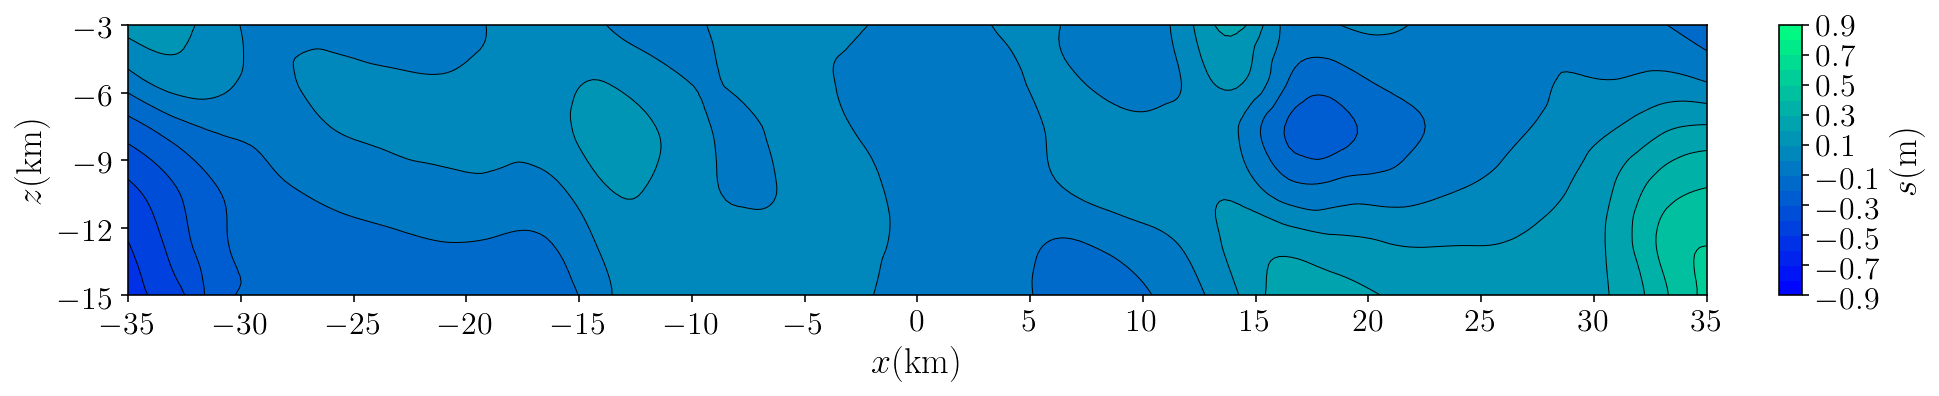

In [84]:
def get_vert_vals(m, x):
    vert_tris = [[] for i in range(m[0].shape[0])]
    for i in range(m[1].shape[0]):
        for d in range(3):
            vert_tris[m[1][i,d]].append(i)
    vert_n_tris = [len(ts) for ts in vert_tris]
    vert_vals = np.zeros(m[0].shape[0])
    for i in range(m[1].shape[0]):
        for d in range(3):
            vert_vals[m[1][i,d]] += x[i]
    vert_vals /= vert_n_tris
    return vert_vals

def make_inversion_plot(x, name, slip_min, slip_max):
    vert_vals = get_vert_vals(fault, x)

    triang = tri.Triangulation(fault[0][:,0] / 1000.0, fault[0][:,2] / 1000.0, fault[1])
    refiner = tri.UniformTriRefiner(triang)
    tri_refi, z_test_refi = refiner.refine_field(vert_vals, subdiv=3)

    plt.figure(figsize = (15, 3.5))
    ax = plt.gca()
    ax.set_aspect('equal')
    # plt.triplot(triang, lw = 0.5, color = 'white')

    levels = np.linspace(slip_min, slip_max, 19)
    # cmap = cm.get_cmap(name='terrain', lut=None)
    cmap = cm.get_cmap(name='winter')
    cntf = plt.tricontourf(tri_refi, z_test_refi, levels=levels, cmap=cmap)
    plt.tricontour(
        tri_refi, z_test_refi, levels=levels,
        linestyles = 'solid',
        colors=['k'],
        linewidths=[0.5]
    )


    plt.xticks(np.linspace(-35.0, 35.0, 15))
    plt.yticks(np.linspace(-3.0, -15.0, 5))
    plt.xlabel('$x \\mathrm{(km)}$')
    plt.ylabel('$z \\mathrm{(km)}$')

    plt.title('')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1.5%", pad=0.5)
    cbar = plt.colorbar(cntf, cax = cax)
    cbar.set_label('$s \\mathrm{(m)}$')
    cbar.set_ticks(levels[::2])
    #cbar.set_ticklabels(levels[::2])
    plt.savefig(name + '.pdf', bbox_inches = 'tight')
    plt.show()

def strike_component(x):
    return x[1::2]

def dip_component(x):
    return x[0::2]
assert(fault[1].shape[0] == xs[0].shape[0] / 2)
make_inversion_plot(-strike_component(xs[0]), 'flat_ss', 0, 4.5)
make_inversion_plot(-dip_component(xs[0]), 'flat_ds', -0.9, 0.9)
make_inversion_plot(-strike_component(xs[1]), 'hill_ss', 0, 4.5)
make_inversion_plot(-dip_component(xs[1]), 'hill_ds', -0.9, 0.9)